# Independence

We would like to measure the strength of the relationship between two variables. _Independence_ is a way to quantify the intuitive notion that two variables are _unrelated_. Once we have defined independence, we can quantify the relationship between two variables by calculating how far they are from independence.

Formally, two variables $X$ and $Y$ are **independent** if the conditional distributions of $Y$ given $X$ (or vice versa) are all _identical_. In other words, the value of $X$ does not affect the distribution of $Y$.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

titanic_df = pd.read_csv("titanic.csv")
titanic_df["adult"] = (titanic_df["age"] >= 18)

For example, consider the relationship between sex and age group (adult or not). First, let's calculate the contingency table:

In [4]:
counts = pd.crosstab(titanic_df.sex, titanic_df.adult)
counts

adult,False,True
sex,,
female,150,316
male,267,576


Although there are more male adults (576) than female adults (316), the _conditional proportion_ of adults, given sex, are actually very close (about $0.68$).

adult,False,True
sex,,
female,0.321888,0.678112
male,0.316726,0.683274


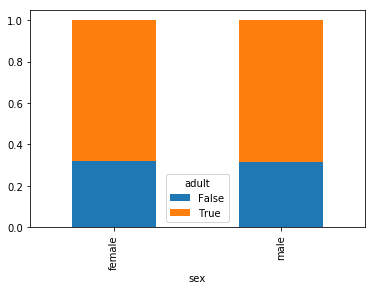

In [5]:
adult_given_sex = counts.divide(counts.sum(axis=1), axis=0)
adult_given_sex.plot.bar(stacked=True)
adult_given_sex 

Because the conditional distribution of `adult` is (approximately) the same, regardless of whether we are conditioning on `sex` = male or `sex` = female, we say that the two variables are (approximately) independent. 

For an example of two non-independent variables, consider passenger class and age group. If we look at the conditional distributions of `adult` given `pclass`, they are not all the same:

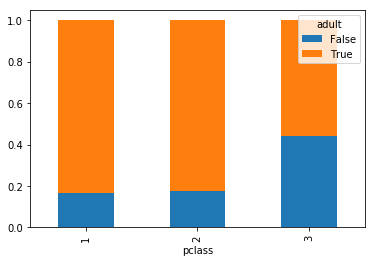

In [6]:
adult_pclass_counts = pd.crosstab(titanic_df.pclass, titanic_df.adult)
(adult_pclass_counts.divide(
    adult_pclass_counts.sum(axis=1), axis=0)
).plot.bar(stacked=True)

The conditional distribution of `adult` given `pclass` = 3 is quite different from the other two conditional distributions. Because the conditional distributions are not all equal, the two variables are _not_ independent. Note that it only takes _one_ conditional distribution to be off to render two variables _not_ independent.

## The Joint Distribution Assuming Independence

What would the joint distribution of passenger class (`pclass`) and age group (`adult`) be, if the two variables were independent? If two variables are independent, then their joint distribution is the product of the marginal distributions. That is,

- $P(\text{1st class and adult}) = P(\text{1st class}) \cdot P(\text{adult})$
- $P(\text{2nd class and adult}) = P(\text{2nd class}) \cdot P(\text{adult})$
- $P(\text{3rd class and adult}) = P(\text{3rd class}) \cdot P(\text{adult})$
- $P(\text{1st class and not adult}) = P(\text{1st class}) \cdot P(\text{not adult})$
- $P(\text{2nd class and not adult}) = P(\text{2nd class}) \cdot P(\text{not adult})$
- $P(\text{3rd class and not adult}) = P(\text{3rd class}) \cdot P(\text{not adult})$

We can calculate the marginal distributions:

In [7]:
# Calculate the total number of passengers.
N = adult_pclass_counts.sum().sum()

# Calculate the marginal distribution of adult by summing over pclass.
adult = adult_pclass_counts.sum(axis=0) / N
adult

adult
False    0.318564
True     0.681436
dtype: float64

In [8]:
# Calculate the marginal distributio nof pclass by summing over adult.
pclass = adult_pclass_counts.sum(axis=1) / N
pclass

pclass
1    0.246753
2    0.211612
3    0.541635
dtype: float64

How do we multiply these two distributions to get a $3 \times 2$ table of the joint distribution, assuming independence? We can use matrix multiplication. We can think of one `Series` as a matrix with 1 column and the other as a matrix with 1 row. Multiplying the two matrices using the usual definition of matrix multiplication gives the desired joint proportions.

$$ {\bf u} {\bf v}^T = \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix} \begin{pmatrix} v_1 & v_2 \end{pmatrix} = \begin{pmatrix} u_1 v_1 & u_1 v_2 \\ u_2 v_1 & u_2 v_2 \\ u_3 v_1 & u_3 v_2 \end{pmatrix} $$

This is an operation in linear algebra known as an **outer product**. To calculate the outer product of two `numpy` arrays, we can use the function `np.outer`:

In [ ]:
np.outer(pclass, adult)

Note that this returns a plain `numpy` `array` instead of a `pandas` `DataFrame`. It turns out that this will be good enough for our purposes.

## Measuring Distance from Independence

We now have, for every combination of our two variables, two proportions:

- the proportion that was actually observed, $P(A \text{ and } B)$
- the proportion that we would expect assuming independence, $P(A) P(B)$

To measure the relationship between two variables, we calculate how far the observed proportions are from what we would expect if the variables were independent. It turns out that there are several ways to calculate the "distance" between two distributions.

**Total Variation Distance**

**Total variation distance** is probably the first distance metric that comes to mind. We calculate the difference and take absolute values before summing so that negative errors don't cancel out positive ones (the motivation for taking absolute values is the same as in MAD, which we learned in Chapter 1): 

$$ TV = \sum_{\text{A, B}} \big|P(A \text{ and } B) - P(A) P(B)\big|. $$

In [ ]:
joint = adult_pclass_counts / N
expected = np.outer(pclass, adult)

# Total Variation Distance
(joint - expected).abs().sum().sum()

Unfortunately, differences turn out to be a bad way to measure distances between proportions. For example, most people would agree that the difference between $0.42$ and $0.41$ is insignificant, but the difference between $0.01$ and $0.00$ is vast. But total variation distance treats both differences the same.

**Chi-Square Distance**

**Chi-square distance** solves the problem of total variation distance by dividing by the difference by expected proportion, effectively calculating the _relative_ difference between the two proportions:

$$ \chi^2 = \sum_{\text{A, B}} \frac{(P(A \text{ and } B) - P(A) P(B))^2}{P(A) P(B)}. $$

In [ ]:
(((joint - expected) ** 2) / expected).sum().sum()

You might be familiar with the chi-square test from a previous statistics class. The chi-square distance is essentially the same as the chi-square test statistic, except for a normalizing constant.

**Mutual Information**

Another popular distance metric is **mutual information**. Whereas chi-square distance tends to be more popular among statisticians, mututal information tends to be more popular among engineers. (It arises from a field called _information theory_.)

$$ I = \sum_{\text{A, B}} P(A \text{ and } B) \log \left( \frac{P(A \text{ and } B)}{P(A) P(B)} \right) $$

In [ ]:
(joint * np.log(joint / expected)).sum().sum()

There is no best distance metric for measuring departures from independence. All three distance metrics above are used in practice. The distances themselves can also be difficult to interpret. But the distance metric can give a rough sense of how closely two variables are related.